In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import io
import requests
import json
from datetime import datetime
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')

In [3]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.covariance import EmpiricalCovariance

In [4]:
#Ignore warnings

import warnings
warnings.filterwarnings('ignore')

# Define functions for analysis

In [5]:

def lengthperiod(week, fmt = '%d/%m/%Y'):
    def _getdays(w):
        tt = []
        for ww in w.split('-'):
            d, m, y = ww.split('/')[0], ww.split('/')[1], ww.split('/')[2]
            if  (m == '02') & (d == '29'):
                if y == '2016' or y == '2020': pass
                else: ww = '28/%s/%s'%(m, y)
            tt.append(datetime.strptime(ww, '%d/%m/%Y'))
        return ((tt[1]-tt[0]).days+1)
    
    if type(week) == str: return _getdays(week)
    else: return np.array([_getdays(w) for w in week])
    
    
    
##Synthetic controls
    

def v_rss(w, z0, z1):                                                                                                                    
    predictions = np.dot(w, z0)                                                                                                           
    errors = z1 - predictions                                                                                                            
    rss = sum(errors**2)                                                                                                                 
    return rss                                                                                                                           


def get_estimate2(z0, z1, z2):                                                                                                             
    j = z0.shape[0]                                                                                                                               
    w = np.array([1.0/j]*j)                                                                                                                       
    v = None                                                                                                                                  
#         controls = fmin_slsqp(v_rss, w, f_eqcons=w_constraintnopred, bounds=[(0.0, 1.0)]*len(w),                                                
#              args=(z0, z1), disp=False, full_output=True)[0]                                                                                    
    weights = minimize(v_rss, w, args=(z0, z1), constraints={'type':'eq', 'fun': lambda t: np.sum(t) - 1}, 
                        bounds=[(0.0, 1.0)]*len(w)).x    
    z_estimates = np.dot(weights, z2)                                                                                                         
    return z_estimates, weights                                                                                                        
                                                                 
def synth(controls, treated, T0):
    '''
    controls : shape(N, T) where N is number of units, T is time series data > T0
    treated : shape(1, T)
    T0 : int, index of intervention
    '''

    Z0, Z1 = controls[:, :T0], treated[:, :T0]
    Z2 = controls.copy()
                                                                                                                         
    return  get_estimate2(Z0, Z1, Z2)                                                   




###############
##PCA

from sklearn.decomposition import PCA


def pcafit(controls, treated, T0, n_components = 2):
    
    pca = PCA(n_components=n_components)
    means = controls.mean(axis=0) 

    pca.fit(controls-means)
    cov = pca.get_covariance()
    icov = pca.get_precision()
    
    def _chisq(p):
        yp = pca.inverse_transform(p)
        diff = treated-means-yp
        diff[T0:] = 0
        return np.dot(np.dot(yp, icov), yp)

    p0 = np.ones(n_components)
    pp = minimize(_chisq, p0, method='Nelder-Mead').x
    yp = pca.inverse_transform(pp)
    yp += means
    return yp, pca, pp

# def conditional_cov(cov, index, given='left'):
#     if given == 'left':
#         cov_yy = cov[index:,index:]
#         cov_xx = cov[:index,:index]
#         cov_xy = cov[:index,index:]
#     elif given == 'right':
#         cov_xx = cov[index:,index:]
#         cov_yy = cov[:index,:index]
#         cov_xy = cov[index:,:index]
        
#     icov_xx = np.linalg.inv(cov_xx)
#     cond_cov  = cov_yy - np.dot(cov_xy.T, np.dot(icov_xx,cov_xy))
#     return cond_cov 

def conditional_gaussian(mean, cov, vals, index, given='left'):
    if given == 'left':
        cov_yy = cov[index:,index:]
        cov_xx = cov[:index,:index]
        cov_xy = cov[:index,index:]
        mean_x = mean[:index]
        mean_y = mean[index:]
    elif given == 'right':
        cov_xx = cov[index:,index:]
        cov_yy = cov[:index,:index]
        cov_xy = cov[index:,:index]
        mean_x = mean[index:]
        mean_y = mean[:index]
        
    icov_xx = np.linalg.inv(cov_xx)
    cond_mean = mean_y + np.dot(cov_xy.T, np.dot(icov_xx, vals-mean_x))
    cond_cov  = cov_yy - np.dot(cov_xy.T, np.dot(icov_xx,cov_xy))
    return cond_mean, cond_cov 


# Collect data from various files

In [6]:
dfmort = pd.read_csv('../../covid-19-data/data/Italy/march28_total_deaths_2015-2020//regional_historic_mortality_fine.tsv', '\t')
dfcovid = pd.read_csv('../../covid-19-data/data/Italy/covid-19-data/regional_daily.tsv', '\t')
dfcovid.insert(0, 'datetime', pd.to_datetime(dfcovid['date']))
dfcovid = dfcovid.drop(columns=['Unnamed: 0'])
vals = dfcovid[dfcovid['region'] == 'Lombardia'][-1:].values
vals[0][4] = "Bergamo"
dfcovid = dfcovid.append(pd.DataFrame(vals.reshape(1, -1), columns=dfcovid.columns))


In [7]:
# Put in manually retrieved Milan data here

milanmean = 232
mm = milanmean
milan = np.array([15, 15, 339-mm, 475-mm, 584-mm])
#true excess deaths in week of 22, 29, 7, 14, 21. Average is 230

In [8]:
# Other data sources such as total population, age distribution etc.

##Age distribution
dfdeathagecvd = pd.read_excel('../../covid-19-data/data/Italy/covid-19-data/covid-19-deaths-by-age-group.xlsx', sheet_name='Data')
dfdeathagecvd = dfdeathagecvd.rename(columns={'Unnamed: 1': 'age'})
dfdeathagecvd = dfdeathagecvd.rename(columns={'Unnamed: 2': 'vals'})
tots = dfdeathagecvd['vals'].sum()
vals = dfdeathagecvd['vals'][4:].values[:-1]
agecvd = vals/vals.sum()

dfagedist = pd.read_csv('../../covid-19-data/data/Italy/regional_pop_dist_bybin.tsv', '\t')
dfagedist = dfagedist.replace('Friuli-Venezia Giulia', 'Friuli Venezia Giulia')
agedict = {}
for i in np.array_split(dfagedist.values, 18):
    agedict[i[0][0]] = i[0][1:]

    
##Population
dfpop = pd.read_csv('../../covid-19-data/data/Italy/march28_total_deaths_2015-2020/regional_population_fraction.tsv', '\t')
vals = np.array([0, 0, 'Bergamo', 243, 243, 1088284, 1088284])
dfpop = dfpop.append(pd.DataFrame(vals.reshape(1, -1), 
                                  columns=dfpop.columns))

dfpop['total_population'] = dfpop['total_population'].astype(int)*1.016
dfpop['mortality_population'] = dfpop['mortality_population'].astype(int)*1.016

##Scaling factor
deathscaling2 = {}
for region in dfpop['region'].values:
    tmp = dfpop[dfpop['region'] == region]
    deathscaling2[region] = (tmp['total_population']/tmp['mortality_population']).values[0]

##Update population to 2019
ratios = []
for region in dfpop['region']:
    v1 = dfpop[dfpop['region'] ==region]['total_population'].values[0]
    try: ratio = agedict[region].sum()/v1
    except: ratio = 1.016
    ratios.append(ratio)
ratios = np.array(ratios)
dfpop['total_population'] *= ratios
dfpop['mortality_population'] *= ratios
    
popdict = dict(dfpop[['region', 'total_population']].values)
popmortdict = dict(dfpop[['region', 'mortality_population']].values)
    
## Get mortality scaling factor    
# dfregdeath = pd.read_csv('../../covid-19-data/data/Italy/regional_deaths_2018.tsv', '\t')
# deathscaling = {}
# for region in np.unique(dfmort['region']):
#     tmp = dfmort[dfmort['region'] == region]
#     weeks = tmp['week'].values
#     total = tmp['total'].values
#     deaths = sum([total[i]  for i in range(weeks.size) if '2018' in weeks[i]])
#     weeks2018 = [weeks[i]  for i in range(weeks.size) if '2018' in weeks[i]]
#     length = lengthperiod(weeks2018[0].split('-')[0]  + '-' + weeks2018[-1].split('-')[1])
#     deaths = deaths/length * 365
#     alldeaths = dfregdeath[dfregdeath['region'] == region]['deaths_2018'].values[0]
#     alldeaths = float(alldeaths.replace(',',''))
#     deathscaling[region] = alldeaths/deaths
    
       

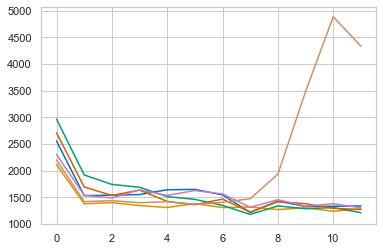

In [9]:
## Visualize data

region0 = 'Lombardia'
vals = dfmort[dfmort['region'] == region0]['total'].values.reshape(22, -1).sum(axis=0).reshape(6, -1)
plt.plot(vals.T)
plt.show()

In [10]:
## Some useful variables

nages = 22
nyears = 6
regions = np.unique(dfmort['region'].values)
region0 = 'Lombardia'
      
T0 = 6


# Predict Counterfactuals

In [11]:
## For total population data

controlsyr, data, scm, pcapreds = {}, {}, {}, {}
l2020, w2020 = 0, 0

for ir, region in enumerate(regions):
    tmp = dfmort[dfmort['region'] ==  region]
    age = tmp['age_group'].values.reshape(nages, -1)
    y = tmp['total'].values.reshape(nages, -1).sum(axis=0)
    weeks = tmp['week'].values.reshape(nages, -1)[0]
    w2020 = weeks.reshape(nyears, -1)[-1]
    x = np.arange(y.size)
    xyr = len(np.array_split(x, nyears)[0])

    length = lengthperiod(weeks)
    l2020 = length.reshape(nyears, -1)[-1]
    yavg = y/length
    
    #weeks = weeks.reshape(nyears, -1) #to check that we are reshaping correctly, this should split rows to years
    if ir == 0: print('Intervention week is : ', weeks.reshape(nyears, -1)[-1][T0]) #This should be week of 15th Feb
    yy = yavg.reshape(nyears, -1)
    controls, treated = yy[:-1], yy[-1]
    means = controls.mean(axis=0)
    controlsyr[region], data[region] = controls, treated
    
    yp, _ = synth(controls, treated.reshape(1, -1), T0)
    scm[region] = yp

    pcs = []
    for i in range(4):
        yp1, pca1, pp1 = pcafit(controls, treated, T0, i)
        pcs.append([yp1, pca1])
    pcapreds[region] = pcs
    


Intervention week is :  16/02/2020-22/02/2020


In [12]:
## For different age bins
#Output error to keep tabs that they correspond to ages<40 and states with less statistics

ageregions = ['Emilia-Romagna', 'Lombardia', 'Piemonte', 'Toscana'] #['Veneto']
agegroups = ['%d-%d'%(i*10, i*10+9) for i in range(0, 10) ]
agegroups[-1] = '90 & above'


ascm, adata, acontrols, apcapreds = {}, {}, {}, {}

for ir, region in enumerate(regions):
    for age in np.arange(10):
        key = region + '%d'%age
        tmp = dfmort[dfmort['region'] ==  region]
        if age == 0:  tmp = tmp[(tmp['age_group'] <  2+age*2)]
        elif age == 10: tmp = tmp[(tmp['age_group'] >=  1+age*2)]
        else: tmp = tmp[(tmp['age_group'] >=  1+age*2) & (tmp['age_group'] <=  2+age*2)]
        nageunique = np.unique(tmp['age_group']).size
        y = tmp['total'].values.reshape(nageunique,-1).sum(axis=0)

        x = np.arange(y.size)
        xyr = len(np.array_split(x, nyears)[0])

        weeks = tmp['week'].values.reshape(nageunique,-1)[0]
        length = lengthperiod(weeks)        

        yavg = y/length        

        yy = yavg.reshape(nyears, -1)
        controls, treated = yy[:-1], yy[-1]
        means = controls.mean(axis=0)
        adata[key] = treated
        acontrols[key] = controls

        yp, _ = synth(controls, treated.reshape(1, -1), T0)
        ascm[key] = yp

        pcs = []
        for i in range(3):
            try: 
                yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
                pcs.append([yp1, pca1])
            except Exception as e: 
                print("Error : ", region, age, i, e)
                pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
        apcapreds[key] = pcs


Error :  Abruzzo 1 1 array must not contain infs or NaNs
Error :  Abruzzo 1 2 array must not contain infs or NaNs
Error :  Basilicata 0 1 array must not contain infs or NaNs
Error :  Basilicata 0 2 array must not contain infs or NaNs
Error :  Basilicata 1 1 array must not contain infs or NaNs
Error :  Basilicata 1 2 array must not contain infs or NaNs
Error :  Calabria 1 1 array must not contain infs or NaNs
Error :  Calabria 1 2 array must not contain infs or NaNs
Error :  Calabria 2 2 array must not contain infs or NaNs
Error :  Friuli Venezia Giulia 0 1 array must not contain infs or NaNs
Error :  Friuli Venezia Giulia 0 2 array must not contain infs or NaNs
Error :  Friuli Venezia Giulia 1 1 array must not contain infs or NaNs
Error :  Friuli Venezia Giulia 1 2 array must not contain infs or NaNs
Error :  Molise 0 1 array must not contain infs or NaNs
Error :  Molise 0 2 array must not contain infs or NaNs
Error :  Molise 1 1 array must not contain infs or NaNs
Error :  Molise 1 2 

# Get official covid numbers

In [13]:
 
    
covid = {}
lcovid2020 = {}
covidcum = {}
covidpos = {}
covidtests = {}
covidcumpos = {}
covidcumtests = {}

for region in regions:
    tmp2 = dfcovid[dfcovid['region'] == region].copy()
    deaths, cumdeath , length = [], [], []
    cumpos, cumtests = [], []
    pos, tests = [], []
    for ww in w2020:
        w0, w1 = ww.split('-')
        t0 = datetime.strptime(w0, '%d/%m/%Y')
        t1 = datetime.strptime(w1, '%d/%m/%Y')
        loc = np.array([True  if ((i - t0).days * (i - t1).days <=0) else False for i in tmp2['datetime']])
        try: 
            cumtests.append(tmp2['swabs'].values[loc][-1])
            cumpos.append(tmp2['total_cases'].values[loc][-1])
            cumdeath.append(tmp2['death'].values[loc][-1])
        except:
            cumdeath.append(0)
            cumtests.append(0)
            cumpos.append(0)
        length.append(loc.sum())
    covidcumtests[region] = np.array(cumtests) 
    covidcumpos[region] = np.array(cumpos)                                   
    covidcum[region] = np.array(cumdeath)

    covidtests[region] = np.array([0] + np.diff(cumtests).tolist()) 
    covidpos[region] = np.array([0] + np.diff(cumpos).tolist())
    covid[region] = np.array([0] + np.diff(cumdeath).tolist())
    lcovid2020[region] = np.array(length)


## Plot all regions to extract important regions

Text(0.5, 0.98, 'Cumulative number of deaths since the beginning of year')

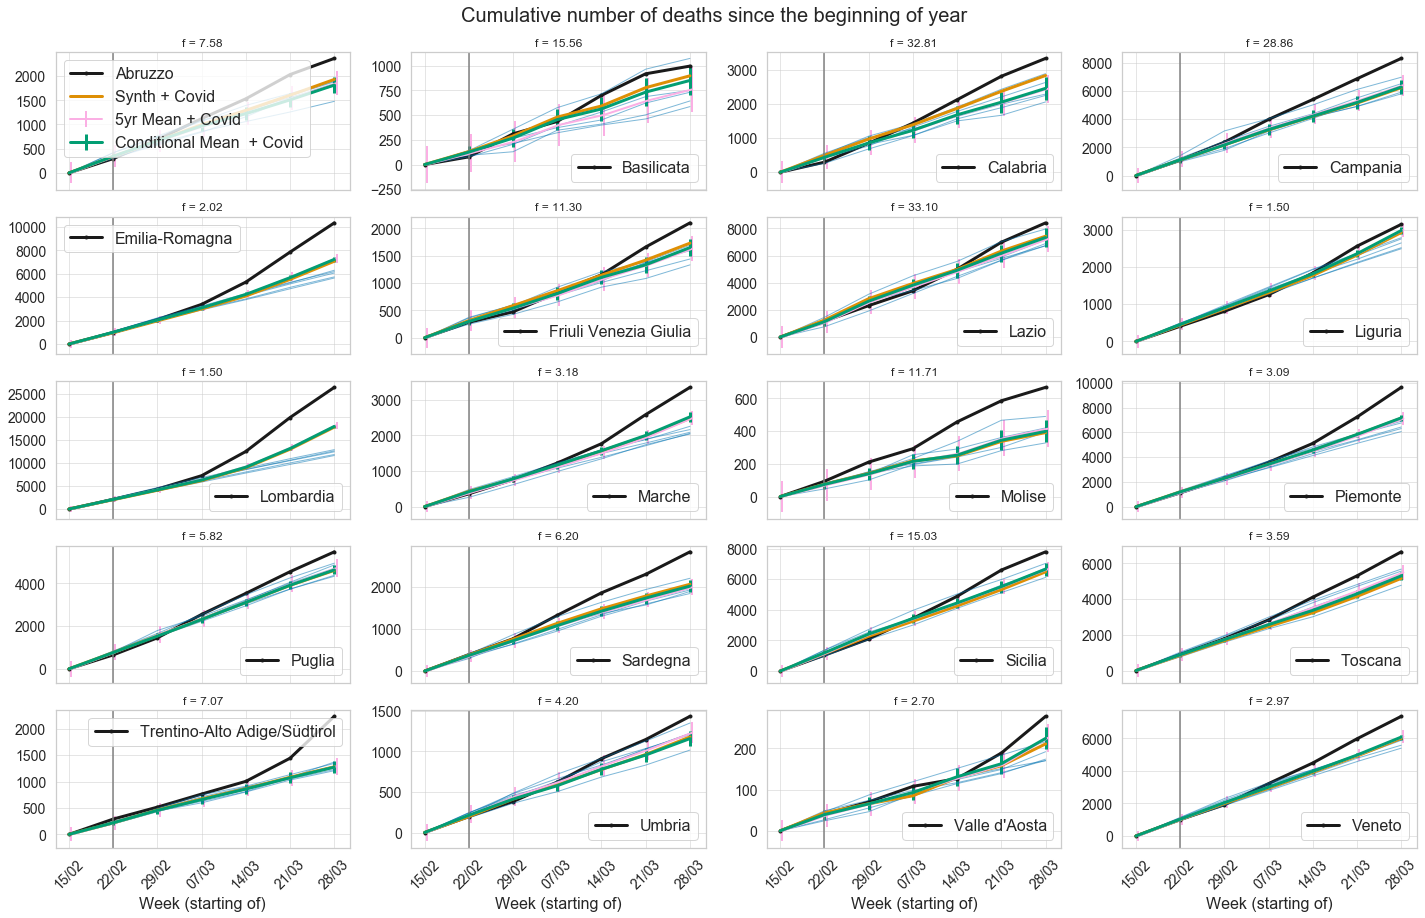

In [14]:
## plot data for all regions and select the ones to focus analysis on

xlab = [i.split('-')[1][:-5] for i in w2020]     

fig, ax = plt.subplots(5, 4, figsize=(20, 13), sharex=True)
axf = ax.flatten()
axn = 0
i0 = T0-1
normi0 = True

for ir, region in enumerate(regions):

    scale = deathscaling2[region]
    
    if 1 : #scale < 10 and ((region != "Valle d'Aosta") & (region != "Liguria")):
        lbl = region
        ddata = data[region]
        dd = np.cumsum(ddata * scale * l2020 )
        x = np.arange(dd.size)
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'k', lw=3, label=lbl, marker='.')
        lbl = None
                

        dd = np.cumsum(controlsyr[region]*scale * l2020, axis=1).T
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'C0', lw=1, alpha=0.5)

        if ir == 0: lbl = '5yr Mean + Covid'        
        means = controlsyr[region].mean(axis=0)
        dd = np.cumsum(means*scale * l2020)
        dd += covidcum[region]
        if normi0 : dd -= dd[i0]
        err = np.cov((controlsyr[region]).T).diagonal()**0.5 *scale * l2020
        err = np.cumsum(err**2)**0.5
        axf[axn].errorbar(x[i0:]+0.05, dd[i0:], err[i0:], color='C6', lw=2, alpha=1, label=lbl)

        if ir == 0: lbl = 'Synth + Covid'        
        dd = np.cumsum(scm[region]*scale * l2020)
        dd += covidcum[region]
        if normi0 : dd -= dd[i0]
        axf[axn].plot(x[i0:], dd[i0:], 'C1', lw=3, alpha=1, label=lbl)

        if ir == 0: lbl = 'Conditional Mean  + Covid'
        ppred, pc = pcapreds[region][2]#pca2, pcameans2
        meancond, covcond = conditional_gaussian(means, pc.get_covariance(), ddata[:T0], T0)
        meancond = np.concatenate([ddata[:T0], meancond])
        dd = np.cumsum(meancond * scale * l2020)
        dd += covidcum[region]        
        if normi0 : dd -= dd[i0]
        errcond = (covcond.diagonal()**0.5)*scale*l2020[T0:]
        errcond = np.concatenate([np.zeros(T0), np.cumsum(errcond**2)**0.5]) 
        axf[axn].errorbar(x[i0:], dd[i0:], errcond[i0:], color='C2', lw=3, alpha=1, label=lbl)

        axf[axn].axvline(x[T0], color='gray')
        axf[axn].legend(fontsize=16, ncol=1)
        axf[axn].grid(which = 'both', lw=0.5)
        axf[axn].set_title('f = %0.2f'%scale)
        axn +=1

for axis in ax[-1,:]:
    axis.set_xticks(np.arange(data[region].size)[i0:])
    axis.set_xticklabels(xlab[i0:])
    axis.set_xlabel('Week (starting of)', fontsize=16)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Cumulative number of deaths since the beginning of year', fontsize=20)

In [15]:
mainregions = np.unique(dfmort['region'])[[4, 8, 9, 11, 12, 13, 15, 19]]
print(mainregions)

['Emilia-Romagna' 'Lombardia' 'Marche' 'Piemonte' 'Puglia' 'Sardegna'
 'Toscana' 'Veneto']


# Extrapolate to April 11

In [16]:
from scipy.optimize import curve_fit as cf
def fitlinear(y, x=None, yerr=None, abserr=True):
    if x is None: x = np.arange(y.size)
    p0 = [1, 1]
#     chisq = lambda p, xx, yy: ((yy - p[0]*xx - p[1])**2).sum()
#     pp = minimize(chisq, p0).x
    chisq = lambda xx, p0, p1: p0*xx + p1
    pp, pcov = cf(chisq, xdata=x, ydata=y, p0=p0, sigma=yerr, absolute_sigma=abserr)
    return pp, pcov 




[285.58611499 276.9404402  276.10555502 264.95251097 270.02931326]
index -1 is out of bounds for axis 0 with size 0


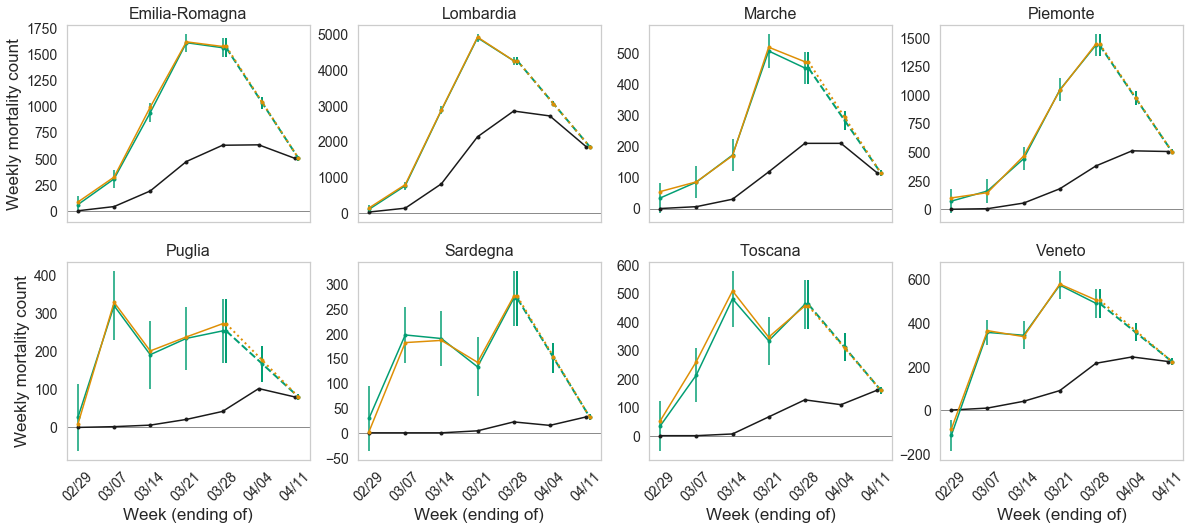

In [17]:
Td = 5 #number of data points we have
isplit = [6] + [6+i*7 for i in range(1, 6)]
xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
xlab[-1] = '04/11'

fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True)
axf = ax.flatten()
axn = 0
i0 = 0

extrapcovid = {}
extrapcgpmean, extrapcgpmeaner = {}, {}
extrapscmmean = {}

extrap = {}
for ir, region in enumerate(regions):
    
    scale = deathscaling2[region]    
    if region in regions : 
        try:
            cumvals = dfcovid[dfcovid['region'] == region]['death'].values
            cumvals = np.split(cumvals, isplit)
            cumvalsw = np.array([i[-1] for i in cumvals])
            cumvalsw[-1] = cumvals[-1][0] + (cumvals[-1][-1] - cumvals[-1][0])*7/cumvals[-1].size
            valsw = np.array([cumvalsw[0]] + np.diff(cumvalsw).tolist())
            extrapcovid[region] = valsw

            means = controlsyr[region].mean(axis=0)
            ddata = data[region].copy()
            ppred, pc = pcapreds[region][2]#pca2, pcameans2
            meancond, covcond = conditional_gaussian(means, pc.get_covariance(), ddata[:T0], T0)
            meancond = np.concatenate([ddata[:T0], meancond])*l2020*scale
            errcond = (covcond.diagonal()**0.5) *scale *l2020[T0:]
            errcond = np.concatenate([np.zeros(T0), errcond]) 
            scmpred =  scm[region]*l2020*deathscaling2[region]

            ddata = ddata*l2020*scale
            if region == 'Lombardia':
                print((1.4*1e6/popdict[region])*meancond[-Td:])
                ddata[-Td:] = (1 -1.4*1e6/popdict[region])*ddata[-Td:]
                ddata[-Td:] += milan
                ddata[-Td:] += milanmean

            excess = (ddata - meancond) 
            excessscm = (ddata - scmpred)
            midp = (excess[-1] + valsw[-1])/2.
            midper = (errcond[-1] + valsw[-1]**0.5)/2.
            midpscm = (excessscm[-1] + valsw[-1])/2.

            extrapcgpmean[region] = np.concatenate([excess[-Td:], [midp], (valsw)[-1:]])
            extrapcgpmeaner[region] = np.concatenate([errcond[-Td:], [midper], (valsw**0.5)[-1:]])
            extrapscmmean[region] = np.concatenate([excessscm[-Td:], [midpscm], (valsw)[-1:]])
        except Exception as e:
            print(e)
            extrapcgpmean[region] = np.zeros(len(xlab))
            extrapcgpmeaner[region] = np.zeros(len(xlab))
            extrapscmmean[region] = np.zeros(len(xlab))
        ##Make fig
        if region in mainregions:
            xplot = np.arange(valsw.size)
            axf[axn].plot(xplot, valsw, marker='.', color='k')
            axf[axn].errorbar(xplot[:Td], excess[-Td:], errcond[-Td:], marker='.', color='C2')
            axf[axn].errorbar(xplot[:Td], excessscm[-Td:],  marker='.', color='C1')
            lbl = None

            axf[axn].errorbar(xplot[Td-1:]+0.1, extrapcgpmean[region][Td-1:], extrapcgpmeaner[region][Td-1:],
                              ls='--', marker='.', color='C2', lw=2)
            axf[axn].errorbar(xplot[Td-1:]+0.1, extrapscmmean[region][Td-1:], ls=':', 
                              marker='.', color='C1', lw=2)

            axf[axn].grid(which='both')
            axf[axn].set_title(region, fontsize=16)
            axn += 1
    

for axis in ax[-1,:]:
    axis.set_xticks(np.arange(valsw.size))
    axis.set_xticklabels(xlab[i0:])
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Weekly mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.axhline(0, color='k', lw=0.5)
    #plt.legend(fontsize=14)


### Extrapolate for age groups

No handles with labels found to put in legend.


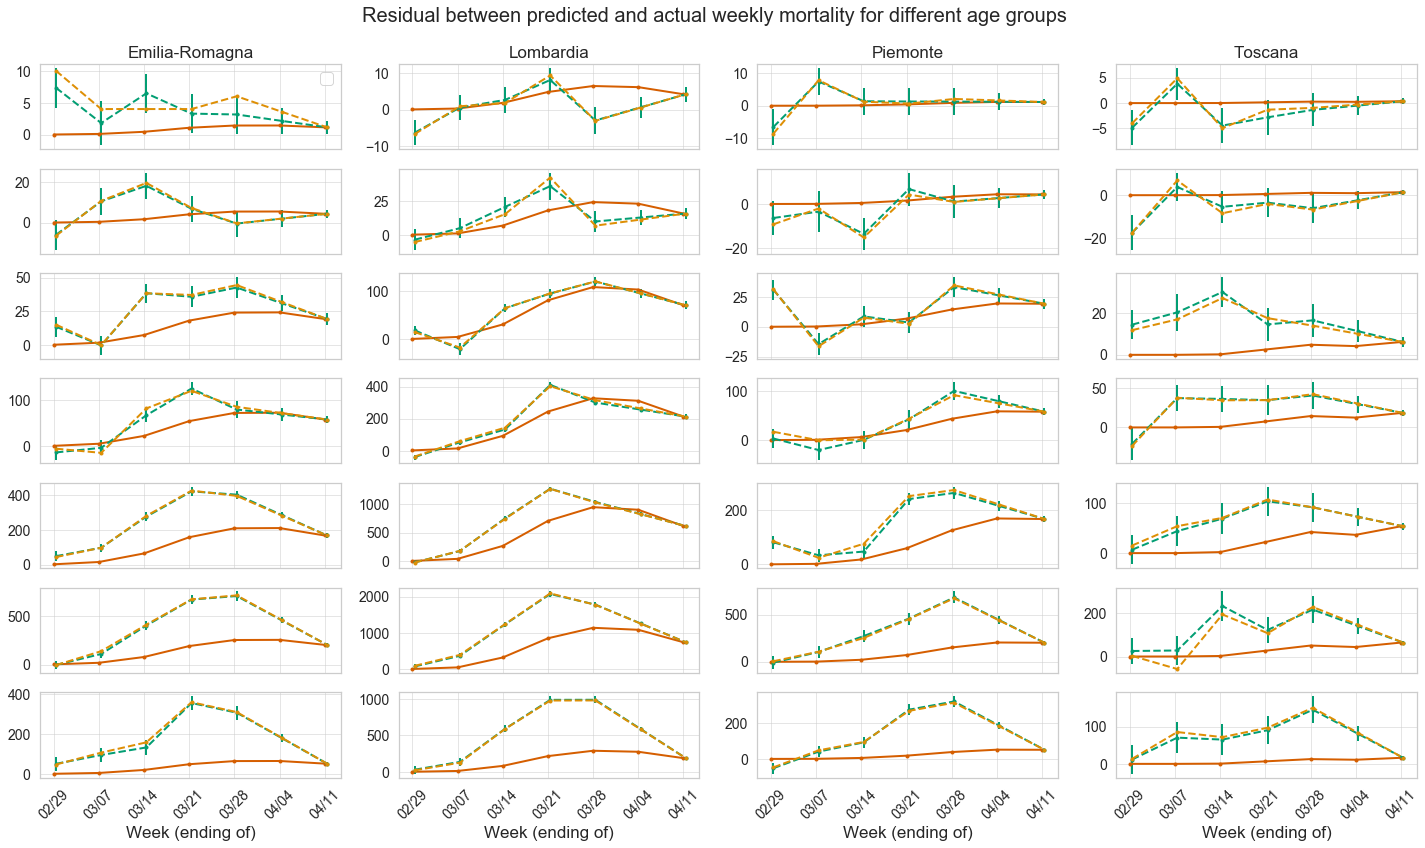

In [18]:
# Do for differet age groups

Td = 5 #number of data points we have
isplit = [6] + [6+i*7 for i in range(1, 6)]
xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
xlab[-1] = '04/11'


aextrapcovid = {}
aextrapcgpmean, aextrapcgpmeaner, aextrapscmmean = {}, {}, {}

for ir, region in enumerate(mainregions):
    
    scale = deathscaling2[region]    
    if region != 'Trentino-Alto Adige/Südtirol' and region!= 'Bergamo': #scale < 10 and ((region != "Valle d'Aosta") & (region != "Liguria")& (region != "Umbria")):
        for age in range( 10):
            key = region + '%d'%age
            cumvals = dfcovid[dfcovid['region'] == region]['death'].values *agecvd[age]
            cumvals = np.split(cumvals, isplit)
            cumvalsw = np.array([i[-1] for i in cumvals])
            cumvalsw[-1] = cumvals[-1][0] + (cumvals[-1][-1] - cumvals[-1][0])*7/cumvals[-1].size
            valsw = np.array([cumvalsw[0]] + np.diff(cumvalsw).tolist())
            aextrapcovid[key] = valsw

            means = acontrols[key].mean(axis=0)
            ddata = adata[key].copy()
            try:
                ppred, pc = apcapreds[key][2]#pca2, pcameans2
                meancond, covcond = conditional_gaussian(means, pc.get_covariance(), ddata[:T0], T0)
                meancond = np.concatenate([ddata[:T0], meancond])
                errcond = (covcond.diagonal()**0.5) *scale *l2020[T0:]
                errcond = np.concatenate([np.zeros(T0), errcond]) 
            except Exception as e:
                aextrapcgpmean[key] = valsw
                aextrapscmmean[key] = valsw
                aextrapcgpmeaner[key] = valsw**0.5

            meancond = meancond.copy()*l2020*scale
            scmpred = ascm[key]*l2020*scale
            ddata = ddata *l2020*scale
            
            if region == 'Lombardia':
                originallomb = data[region]*l2020*deathscaling2[region]
                newlomb = (1 -1.4*1e6/popdict[region])*originallomb[-Td:]
                newlomb[-Td:] += milan
                newlomb[-Td:] += milanmean
                milanratio = newlomb[-Td:] / originallomb[-Td:]
                ddata[-Td:] *= milanratio


            excess = (ddata - meancond) 
            excessscm = (ddata - scmpred) 
            midp = (excess[-1] + valsw[-1])/2.
            midper = (errcond[-1] + valsw[-1]**0.5)/2.
            midpscm = (excessscm[-1] + valsw[-1])/2.

            aextrapcgpmean[key] = np.concatenate([excess[-Td:], [midp], (valsw)[-1:]])
            aextrapcgpmeaner[key] = np.concatenate([errcond[-Td:], [midper], (valsw**0.5)[-1:]])
            aextrapscmmean[key] = np.concatenate([excessscm[-Td:], [midpscm], (valsw)[-1:]])
                

                
fig, ax = plt.subplots(7, 4, figsize=(20, 12), sharex=True)
axf = ax.flatten()
axn = 0 
i0 = T0+1
normi0 = False

for ia, age in enumerate(range(3, 10)):
    for ir, region in enumerate(ageregions):
        key = region + '%d'%age
        xplot = np.arange(aextrapcovid[key].size)
        axf[axn].plot(xplot, aextrapcovid[key], marker='.', lw=2, color='r')
        #
        axf[axn].errorbar(xplot[:]+0.05, aextrapcgpmean[key][:], aextrapcgpmeaner[key][:], 
                          color='C2', ls = "--", marker='.', lw=2)
        axf[axn].errorbar(xplot[:]+0.05, aextrapscmmean[key][:],
                          color='C1', ls = "--", marker='.', lw=2)

        if axn == 0: axf[axn].legend(fontsize=16, ncol=1, loc=0)
        axf[axn].grid(which = 'both', lw=0.5)
        if axn < 4:axf[axn].set_title(region, fontsize=17)
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot)
    axis.set_xticklabels(xlab)
    axis.set_xlabel('Week (ending of)', fontsize=17)
# for axis in ax[:,0]:
#     axis.set_ylabel('Total mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Residual between predicted and actual weekly mortality for different age groups', fontsize=20)
plt.show()

# Repeat the analysis for Bergamo

In [19]:
## Get the data
mainregionsb = mainregions.tolist() + ['Bergamo']

#
dfread = pd.read_csv('../../covid-19-data/data/Italy/march28_total_deaths_2015-2020/raw_data/comune-giorno/comune_giorno.csv', encoding='latin1')
df = dfread[dfread['NOME_PROVINCIA'] == 'Bergamo']
del dfread

df = df.rename(columns={'NOME_COMUNE':'town', 'NOME_REGIONE':'region', 'NOME_PROVINCIA':'province', 'CL_ETA':'ages', 'GE':'dates'})
df = df[df['dates'] <=328]
dfwaste = df[(df['TOTALE_20'] == 9999)]
dfcut = df[~(df['TOTALE_20'] == 9999).values]

weeks = ['01/01/2015-11/01/2015', '12/01/2015-18/01/2015',
             '19/01/2015-25/01/2015', '26/01/2015-01/02/2015',
             '02/02/2015-08/02/2015', '09/02/2015-15/02/2015',
            '16/02/2015-22/02/2015', '23/02/2015-29/02/2015',
             '01/03/2015-07/03/2015', '08/03/2015-14/03/2015',
             '15/03/2015-21/03/2015', '22/03/2015-28/03/2015']
colsave = ['week', 'region', 'age_group', 'male', 'female', 'total']
ages = np.arange(22)
years = [15, 16, 17, 18, 19, 20]
dates = [[101, 111], [112, 118], [119, 125], [126, 201], [202, 208], [209, 215], [216, 222], [223, 229],
    [301, 307], [308, 314], [315, 321], [322, 328]]

tmp = dfcut
dfmortb = pd.DataFrame(columns=colsave, dtype=None)
for ia, age in enumerate(ages):
    tmpa = tmp[(tmp['ages'] == age)]
    for year in years:
        cols = ['MASCHI_%d'%year, 'FEMMINE_%d'%year, 'TOTALE_%d'%year]
        weeklabel = [i[:8] + '%d'%year + i[10:-2]+ '%d'%year for i in weeks]

        for iw, week in enumerate(weeks):
            tmpw = tmpa[(tmpa['dates'] >= dates[iw][0]) & (tmpa['dates'] <= dates[iw][1])]
            deaths = tmpw[cols].sum().astype(float).tolist()
            entry = np.array([weeklabel[iw], 'Bergamo', ia] + deaths).reshape(1, -1)
            dfmortb = dfmortb.append(pd.DataFrame(entry, columns=colsave), ignore_index=True)

dfmortb['age_group'] = dfmortb['age_group'].astype(int)
dfmortb['male'] = dfmortb['male'].astype(float)
dfmortb['female'] = dfmortb['female'].astype(float)
dfmortb['total'] = dfmortb['total'].astype(float)

deathscaling2['Bergamo'] = 1


### Covid data for Bergamo

In [20]:
bergamodata = np.array([0, 0, 0, 261, 1085, 1759, 2425, 2693])  ##Cumulative data read manually for Bergamo
bergamoagedata = np.array([0, 0, 0, 3, 25, 98, 361, 917, 881, 140]) ## age distribution read manually 

## Weekly numbers copied for different age groups below, should add upto numbers in bergamoagedata
# 22+17+27+24+29+38+44+47+44+69
# 66+88+88+90+79+101+95+99+87+124
# 114+116+106+84+105+85+83+76+66+46
# 31+30+31+15+12+8+6+1+5+1


### Coutnerfactuals for Bergamo and extrapolation

In [21]:

l2020, w2020 = 0, 0

tmp = dfmortb.copy()
age = tmp['age_group'].values.reshape(nages, -1)
y = tmp['total'].values.reshape(nages, -1).sum(axis=0)
weeks = tmp['week'].values.reshape(nages, -1)[0]
w2020 = weeks.reshape(nyears, -1)[-1]
x = np.arange(y.size)
xyr = len(np.array_split(x, nyears)[0])

length = lengthperiod(weeks)
l2020 = length.reshape(nyears, -1)[-1]
yavg = y/length

#weeks = weeks.reshape(nyears, -1) #to check that we are reshaping correctly, this should split rows to years
if ir == 0: print('Intervention week is : ', weeks.reshape(nyears, -1)[-1][T0]) #This should be week of 15th Feb
yy = yavg.reshape(nyears, -1)
controlsb, treatedb = yy[:-1], yy[-1]
datab = treatedb.copy()

yp, _ = synth(controlsb, treatedb.reshape(1, -1), T0)
scmb = yp

yp1, pca1, pp1 = pcafit(controls, treated, T0, 2)
pcapredsb = [yp1, pca1]


data['Bergamo'] = datab
scm['Bergamo'] = scmb
pcapreds['Bergamo'] = [0, 0, pcapredsb, 0]
controlsyr['Bergamo'] = controlsb

########################

adatab, ascmb, apcapredsb, acontrolsb = {}, {}, {}, {}

region = 'Bergamo'
for age in np.arange(10):
    key = region + '%d'%age
    tmp = dfmortb[dfmortb['region'] ==  region]
    if age == 0:  tmp = tmp[(tmp['age_group'] <  2+age*2)]
    elif age == agegroups[-1]: tmp = tmp[(tmp['age_group'] >=  1+age*2)]
    else: tmp = tmp[(tmp['age_group'] >=  1+age*2) & (tmp['age_group'] <=  2+age*2)]
    nageunique = np.unique(tmp['age_group']).size
    y = tmp['total'].values.reshape(nageunique,-1).sum(axis=0)

    x = np.arange(y.size)
    xyr = len(np.array_split(x, nyears)[0])

    weeks = tmp['week'].values.reshape(nageunique,-1)[0]
    length = lengthperiod(weeks)        
    yavg = y/length        

    yy = yavg.reshape(nyears, -1)
    controls, treated = yy[:-1], yy[-1]
    means = controls.mean(axis=0)
    adatab[key] = treated
    acontrolsb[key] = controls

    yp, _ = synth(controls, treated.reshape(1, -1), T0)
    ascmb[key] = yp

    pcs = []
    for i in range(3):
        try: 
            yp1, pca1, pp1 = pcafit(controls, treated, T0, i) 
            pcs.append([yp1, pca1])
        except Exception as e: 
            print(region, age, i, e)
            pcs.append([np.zeros_like(treated), PCA(i).fit(controls-means)])
    apcapredsb[key] = pcs

########################   
    
ppred, pc = pcapredsb
means = controlsb.mean(axis=0)
meancond, covcond = conditional_gaussian(means, pc.get_covariance(), datab[:T0], T0)
meancond = np.concatenate([datab[:T0], meancond])
errcond = (covcond.diagonal()**0.5)*scale*l2020[T0:]
errcond = np.concatenate([np.zeros(T0), errcond]) 
excessbcgp = (datab - meancond)*l2020 

extrapcgpmean['Bergamo'] = np.concatenate([excessbcgp[-Td:], [0, 0]])
extrapcgpmean['Bergamo'][-1] = np.diff(bergamodata)[-1]
extrapcgpmean['Bergamo'][-2] = extrapcgpmean['Bergamo'][[-1, -3]].mean()
extrapcgpmeaner['Bergamo'] = np.concatenate([errcond[-Td:], extrapcgpmean['Bergamo'][-2:]**0.5])

excessbscm = (datab - scmb)*l2020 
extrapscmmean['Bergamo'] = np.concatenate([excessbscm[-Td:], [0, 0]])
extrapscmmean['Bergamo'][-1] = np.diff(bergamodata)[-1]
extrapscmmean['Bergamo'][-2] = extrapscmmean['Bergamo'][[-1, -3]].mean()

extrapcovid['Bergamo'] = np.diff(bergamodata)
for ia, age in enumerate(range(10)):
    key = 'Bergamo%d'%age

    excessbscm = (adatab[key] - ascmb[key])*l2020 

    ppred, pc = apcapredsb[key][2]
    means = acontrolsb[key].mean(axis=0)
    meancond, covcond = conditional_gaussian(means, pc.get_covariance(), adatab[key][:T0], T0)
    meancond = np.concatenate([adatab[key][:T0], meancond])
    excessbcgp = (adatab[key] - meancond)*l2020 
    errcond = (covcond.diagonal()**0.5)*scale*l2020[T0:]
    errcond = np.concatenate([np.zeros(T0), errcond]) 

    frac = bergamoagedata[age]/bergamoagedata.sum()
    aextrapcgpmean[key] = np.concatenate([excessbcgp[-Td:], [0, 0]])
    aextrapcgpmean[key][-1] = np.diff(bergamodata)[-1] *frac
    aextrapcgpmean[key][-2] = aextrapcgpmean[key][[-1, -3]].mean()
    app = aextrapcgpmean[key][-2:]**0.5
    app[np.isnan(app)] = 0
    aextrapcgpmeaner[key] = np.concatenate([errcond[-Td:], app])

    aextrapscmmean[key] = np.concatenate([excessbscm[-Td:], [0, 0]])
    aextrapscmmean[key][-1] = np.diff(bergamodata)[-1] *frac
    aextrapscmmean[key][-2] = aextrapscmmean[key][[-1, -3]].mean()
    

    aextrapcovid['Bergamo%d'%age] = np.diff(bergamodata) * frac


# Get lower bound on IFR from the extrapolated data

Text(0.5, 0.98, 'Infection Fatality Rate (in %) from cumulative statistics since the intervention at T=T0)')

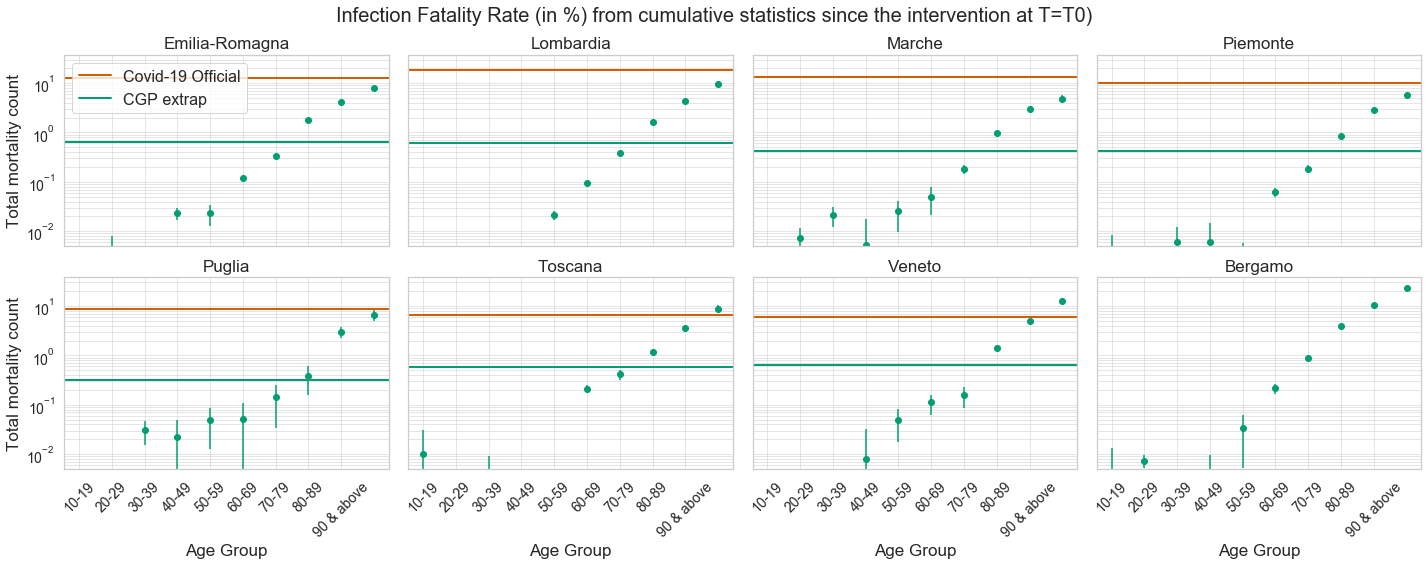

In [22]:
xlab = [i.split('-')[0][:-5] for i in w2020]     

fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axf = ax.flatten()
axn = 0
i0 = T0
mss = ['^', 'v', 's', 's','1', '2', '3', '4', 'P', 'd']

axn = 0 

ifrcgp_ex, ifrcgper_ex = {}, {}
ifrtot_ex  = {}
cfrcvd_ex  = {}
fpositive_ex = {}

for ir, region in enumerate(mainregions.tolist() + ['Bergamo']):
    
    scale = deathscaling2[region]

#     if region in mainregions :
    pop = dfpop[dfpop['region'] == region]['total_population'].values[0]
    tmp = dfcovid[dfcovid['region'] == region]
    fpos = (tmp[-1:]['total_cases']/tmp[-1:]['swabs']).values[0]

    ##
    if axn == 0 : lbl = 'Covid-19 Official'
    excess = extrapcovid[region].sum()
    cvpos = dfcovid[dfcovid['region'] == region]['total_cases'].values[-1]
    infection_ratecvd = excess / cvpos *100
    if region in mainregions: axf[axn].axhline(infection_ratecvd, color='r', label=lbl, alpha=1, lw=2)

    ###
    lbl = 'CGP extrap'
    excess = extrapcgpmean[region].sum() 
    infection_rate = excess / pop /fpos *100
    excesser = extrapcgpmeaner[region].sum() 
    infection_rateer = excesser / pop /fpos *100
    if region in mainregions: axf[axn].axhline(infection_rate, color='C2', label=lbl, alpha=1, lw=2)

    cfrcvd_ex[region] = infection_ratecvd
    ifrtot_ex[region] = [infection_rate, infection_rateer]
    fpositive_ex[region] = [fpos]

    ircgp, ircgper = [], []
    for ia, age in enumerate(range(10)):
        key = region + '%d'%age

        #########
        lbl = None
        if axn == 1: lbl = agegroups[age]

        pop = dfpop[dfpop['region'] == region]['total_population'].values[0]
        agedist =  dfagedist[dfagedist['region'] == region].values[0][1:].astype(float)
        agedist = agedist/agedist.sum()
        pop *= agedist[age]
        excess = aextrapcgpmean[key].sum() 
        infection_rate = excess / pop /fpos *100
        err = (aextrapcgpmeaner[key]**2).sum()**0.5
        err = err / pop /fpos *100            

        ircgp.append(infection_rate)
        ircgper.append(err)

    ifrcgp_ex[region] = np.array(ircgp)
    ifrcgper_ex[region] = np.array(ircgper)

    if region in mainregionsb:
        if region == 'Sardegna': continue
        xx = np.arange(len(agegroups[:]))
        axf[axn].errorbar(xx, ircgp, ircgper, fmt='o', color='C2', alpha=1)

        #######
        if axn ==0 : axf[axn].legend(fontsize=16, ncol=1, loc=2)
        axf[axn].grid(which = 'both', lw=0.5)
        axf[axn].set_title(region, fontsize=17)
        axn +=1


for axis in ax[-1,:]:
    axis.set_xticks(np.arange(len(agegroups[1:])))
    axis.set_xticklabels(agegroups[1:])
    axis.set_xlabel('Age Group', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Total mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale('log')
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Infection Fatality Rate (in %) from cumulative statistics since the intervention at T=T0)', fontsize=20)

# Final figures

###  plot counterfactuals

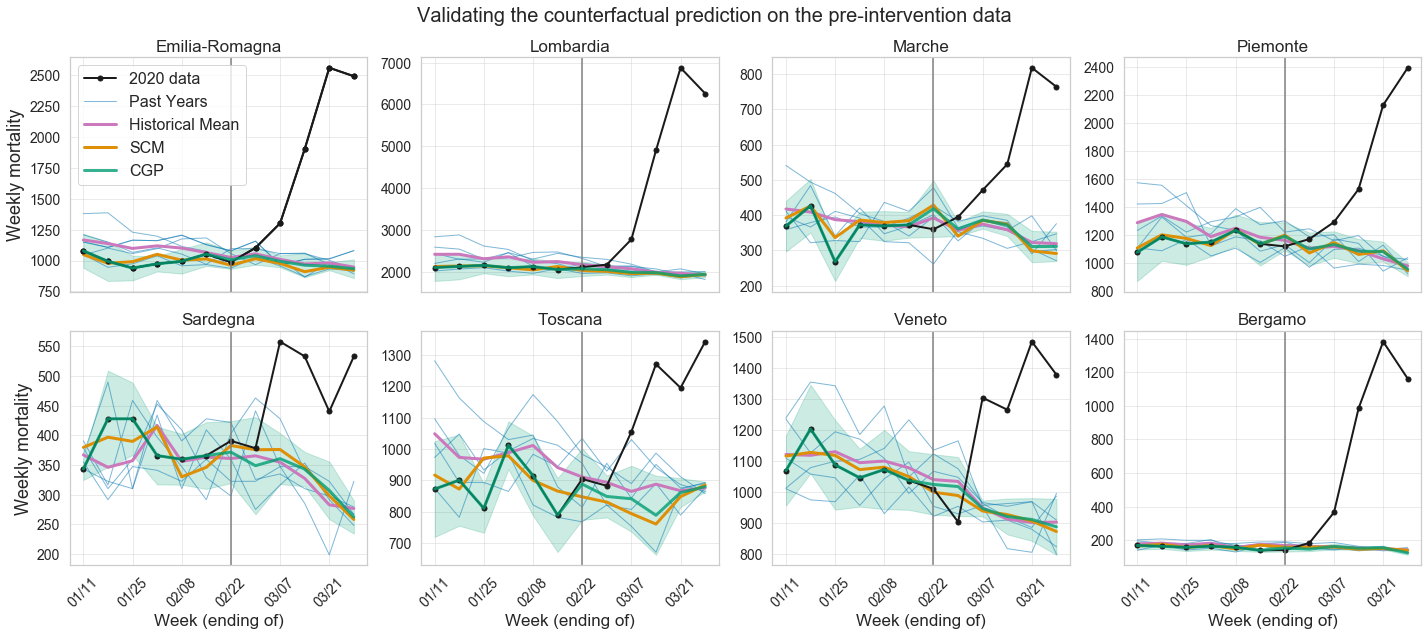

In [23]:
###  plot counterfactuals

l20202 = l2020.copy()
l20202[0] = 7

xlab = [i.split('-')[1][:-5] for i in w2020]     
xlab = [i.split('/')[1]+'/'+i.split('/')[0] for i in xlab]     

fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)
axf = ax.flatten()
axn = 0
i0 = 0

for ir, region in enumerate(mainregionsb):

    scale = deathscaling2[region]
    
    if region in mainregionsb : 
        if region == 'Puglia' : continue
        lbl = region
        ddata = (data[region])*scale * l20202 
        x = np.arange(ddata.size)
        lbl = None
        
        if axn == 0: 
            lbl = '2020 data'        
            dd = (data[region])*scale * l20202 
            if region != region0: axf[axn].plot(dd, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)
            else: 
                td = dd.copy()
                td[-5:] = (1 -1.3*1e6/popdict[region])*td[-5:]
                td[-5:] += milan
                td[-5:] += milanmean
                axf[axn].plot(td, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)

        
        if axn == 0: lbl = None        
        dd = (controlsyr[region] *scale * l20202).T
        axf[axn].plot(x[i0:], dd[:, i0:], color='C0', lw=1, alpha=0.5, label=lbl)
        if ir == 0: axf[axn].plot(x[i0:], dd[:, 0], color='C0', lw=1, alpha=0.5, label='Past Years')

        if axn == 0: lbl = 'Historical Mean'        
        means = controlsyr[region].mean(axis=0)
        dd = (means*scale * l20202)
        err = np.cov((controlsyr[region]).T).diagonal()**0.5 *scale * l20202
        axf[axn].plot(x[i0:], dd[i0:], color='C4', lw=3, alpha=1, label=lbl)
#         axf[axn].fill_between(x[i0:], dd[i0:]-err[i0:], dd[i0:]+err[i0:], color='C5', alpha=0.2)

        if axn == 0: lbl = 'SCM'        
        dd = (scm[region]*scale * l20202) 
#         dd = ddata - dd
        axf[axn].plot(x[i0:], dd[i0:], 'C1', lw=3, alpha=1, label=lbl)

        if axn == 0: lbl = 'CGP'
        ppred, pc = pcapreds[region][2]#pca2, pcameans2
        meancond, covcond = conditional_gaussian(means, pc.get_covariance(), data[region][:T0], T0)
        meancond = np.concatenate([data[region][:T0], meancond])
        dd = (meancond * scale * l20202) 
#         dd = ddata - dd
        errcond = (covcond.diagonal()**0.5)*scale*l20202[T0:]
        errcond = np.concatenate([np.zeros(T0), errcond]) 
        axf[axn].errorbar(x[i0:], dd[i0:],  ls="-", color='C2', lw=3, alpha=0.8, label=lbl)
        axf[axn].fill_between(x[i0:], dd[i0:]-err[i0:], dd[i0:]+err[i0:], color='C2', alpha=0.2)

        lbl = None        
        dd = (data[region])*scale * l20202 
        if region != region0: axf[axn].plot(dd, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)
        else: 
            td = dd.copy()
            td[-5:] = (1 -1.3*1e6/popdict[region])*td[-5:]
            td[-5:] += milan
            td[-5:] += milanmean
            axf[axn].plot(td, 'k', label=lbl, marker='o', lw=2, alpha=1, markersize=5)


        axf[axn].axvline(x[T0], color='gray')
        if axn == 0: axf[axn].legend(fontsize=16, ncol=1)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].set_title(region, fontsize=17)
        axn +=1

for axis in ax[-1,:]:
    axis.set_xticks(np.arange(data[region].size)[i0::2])
    axis.set_xticklabels(xlab[i0::2])
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Weekly mortality', fontsize=18)
# fig.text(0.0, 0.55, 'Weekly mortality', ha='center', va='center', rotation='vertical', fontsize=19)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Validating the counterfactual prediction on the pre-intervention data', fontsize=20)
# plt.savefig('../paper_figs/counterfactuals.pdf')
# plt.savefig('../paper_figs/counterfactuals.jpeg', dpi=300)
plt.show()

###  plot weekly residuals for population


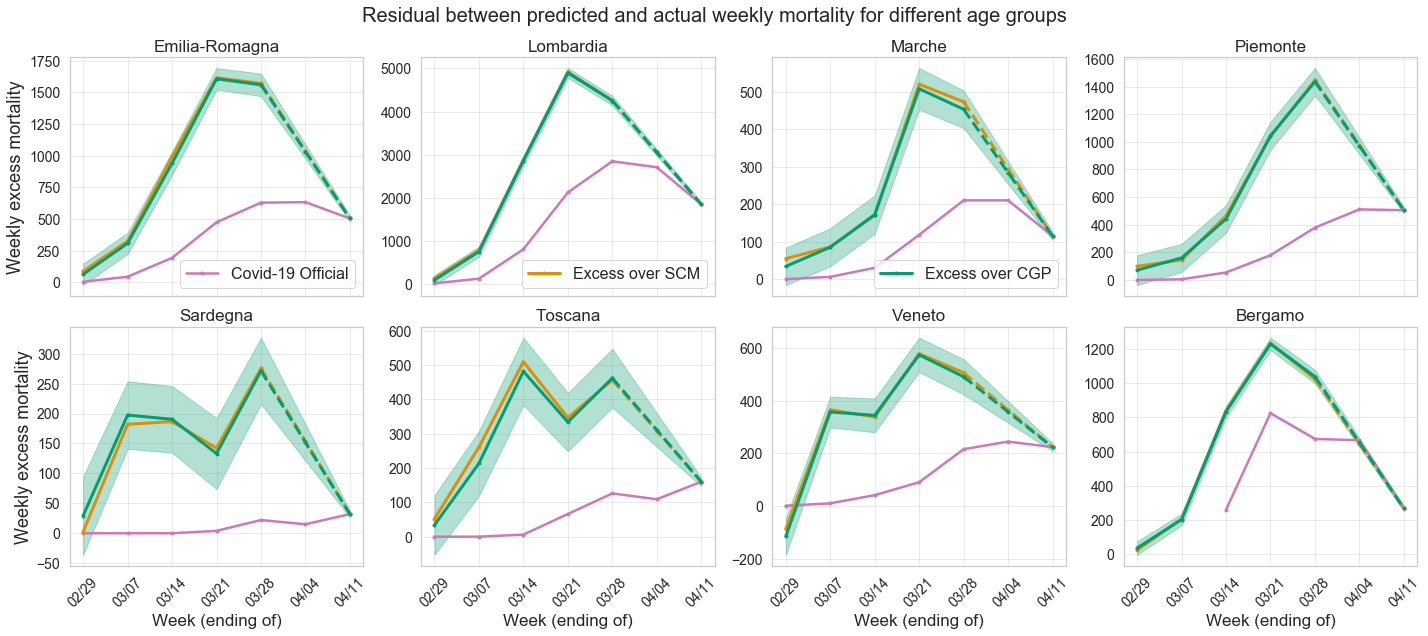

In [24]:
###  plot weekly residuals for population


Td = 5 #number of data points we have
isplit = [6] + [6+i*7 for i in range(1, 6)]
xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
xlab[-1] = '04/11'

fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)
axf = ax.flatten()
axn = 0 
i0 = T0+1
normi0 = False

for ir, region in enumerate(mainregionsb):
    if axn < 8:
        if region == 'Puglia' : continue
        scale = deathscaling2[region]
        key = region
        xplot = np.arange(extrapcovid[key].size)


        lbl = None
        if axn == 0: lbl = "Covid-19 Official"
        yy = extrapcovid[key]
        if region == 'Bergamo': axf[axn].plot(xplot[2:], yy[2:], marker='.', lw=2.5, color='C4', label=lbl)
        else: axf[axn].plot(xplot, yy, marker='.', lw=2.5, color='C4', label=lbl)
        #

        lbl = None
        if axn == 1: lbl = "Excess over SCM"
        dd = extrapscmmean[key]
        axf[axn].errorbar(xplot[:Td], dd[:Td], 
                          color='C1', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td-1:], dd[Td-1:], 
                          color='C1', ls = "--", marker='.', lw=3)
        

        lbl = None
        if axn == 2: lbl = "Excess over CGP"
        dd = extrapcgpmean[key]

        axf[axn].errorbar(xplot[:Td], dd[:Td],  
                          color='C2', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td-1:], dd[Td-1:],  
                          color='C2', ls = "--", marker='.', lw=3)
        axf[axn].fill_between(xplot, 
                              dd - extrapcgpmeaner[key], 
                              dd + extrapcgpmeaner[key], 
                              color='C2', alpha=0.3)
        

        if axn in [0, 1, 2]: axf[axn].legend(fontsize=16, ncol=1, loc=0)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].set_title(region, fontsize=17)
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot)
    axis.set_xticklabels(xlab)
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Weekly excess mortality', fontsize=18)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Residual between predicted and actual weekly mortality for different age groups', fontsize=20)
# plt.savefig('../paper_figs/residuals_weekly.pdf')
# plt.savefig('../paper_figs/residuals_weekly.jpeg')
plt.show()

###  plot cumulative residuals for population


Text(0.5, 0.98, 'Residual between predicted and actual weekly mortality for different age groups')

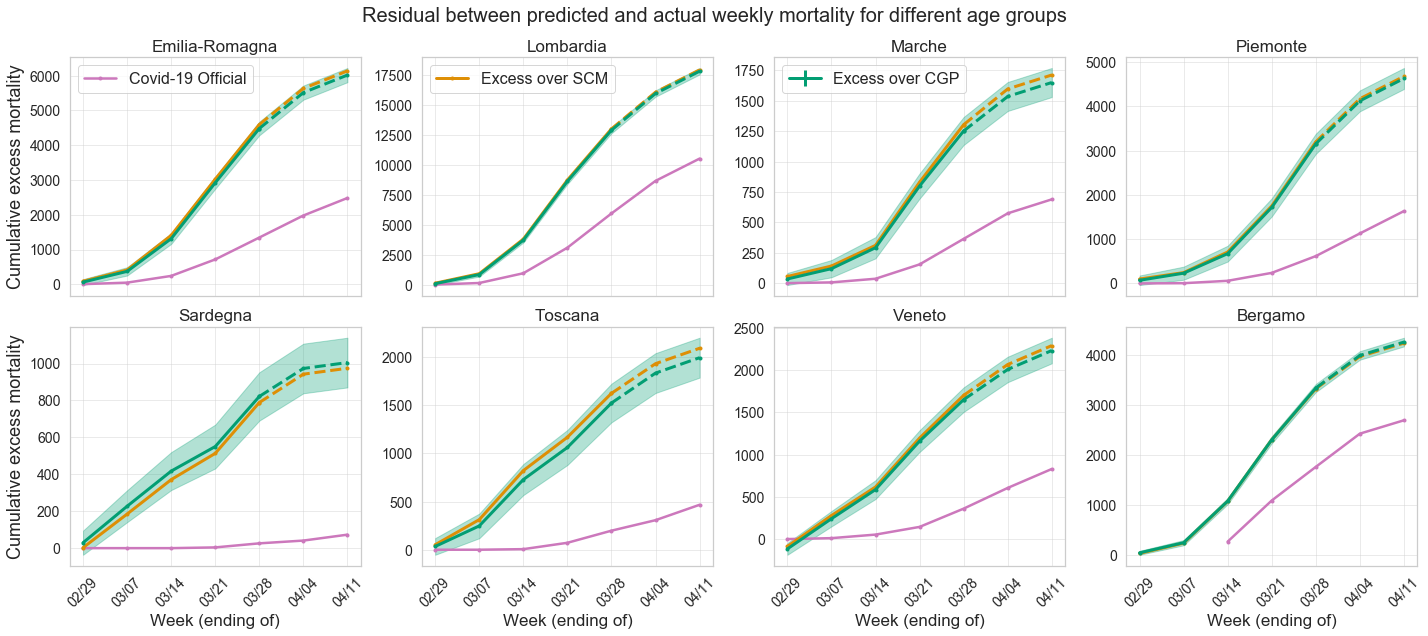

In [25]:
###  plot cumulative residuals for population

Td = 5 #number of data points we have
isplit = [6] + [6+i*7 for i in range(1, 6)]
xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
xlab[-1] = '04/11'

fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)
axf = ax.flatten()
axn = 0 
i0 = T0+1
normi0 = False

for ir, region in enumerate(mainregionsb):
    if axn < 8:
        if region == 'Puglia' : continue
        scale = deathscaling2[region]
        key = region
        xplot = np.arange(extrapcovid[key].size)

        lbl = None
        if axn == 0: lbl = "Covid-19 Official"
        yy = np.cumsum(extrapcovid[key])
        if region == 'Bergamo': axf[axn].plot(xplot[2:], yy[2:], marker='.', lw=2.5, color='C4', label=lbl)
        else: axf[axn].plot(xplot, yy, marker='.', lw=2.5, color='C4', label=lbl)
#         axf[axn].plot(xplot, yy, marker='.', lw=3, color='r', label=lbl)
        #
        lbl = None
        if axn == 1: lbl = "Excess over SCM"
        yy = np.cumsum(extrapscmmean[key])
        axf[axn].errorbar(xplot[:Td], yy[:Td], 
                          color='C1', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td-1:], yy[Td-1:], 
                          color='C1', ls = "--", marker='.', lw=3)

        lbl = None
        if axn == 2: lbl = "Excess over CGP"
        yy = np.cumsum(extrapcgpmean[key])
        yyerr = np.cumsum(extrapcgpmeaner[key]**2)**0.5  * 0
        axf[axn].errorbar(xplot[:Td], yy[:Td], yyerr[:Td], 
                          color='C2', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td-1:], yy[Td-1:], yyerr[Td-1:], 
                          color='C2', ls = "--", marker='.', lw=3)
        yyerr = np.cumsum(extrapcgpmeaner[key]**2)**0.5  
        axf[axn].fill_between(xplot, yy-yyerr, yy+yyerr,
                          color='C2', alpha=0.3)
        
        


        if axn in [0, 1, 2]: axf[axn].legend(fontsize=16, ncol=1, loc=0)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].set_title(region, fontsize=17)
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot)
    axis.set_xticklabels(xlab)
    axis.set_xlabel('Week (ending of)', fontsize=17)
for axis in ax[:,0]:
    axis.set_ylabel('Cumulative excess mortality', fontsize=18)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    
plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Residual between predicted and actual weekly mortality for different age groups', fontsize=20)
# plt.savefig('../paper_figs/residuals_cumulative.pdf')
# plt.savefig('../paper_figs/residuals_cumulative.jpeg')


###  plot cumulative residuals for diferent age groups


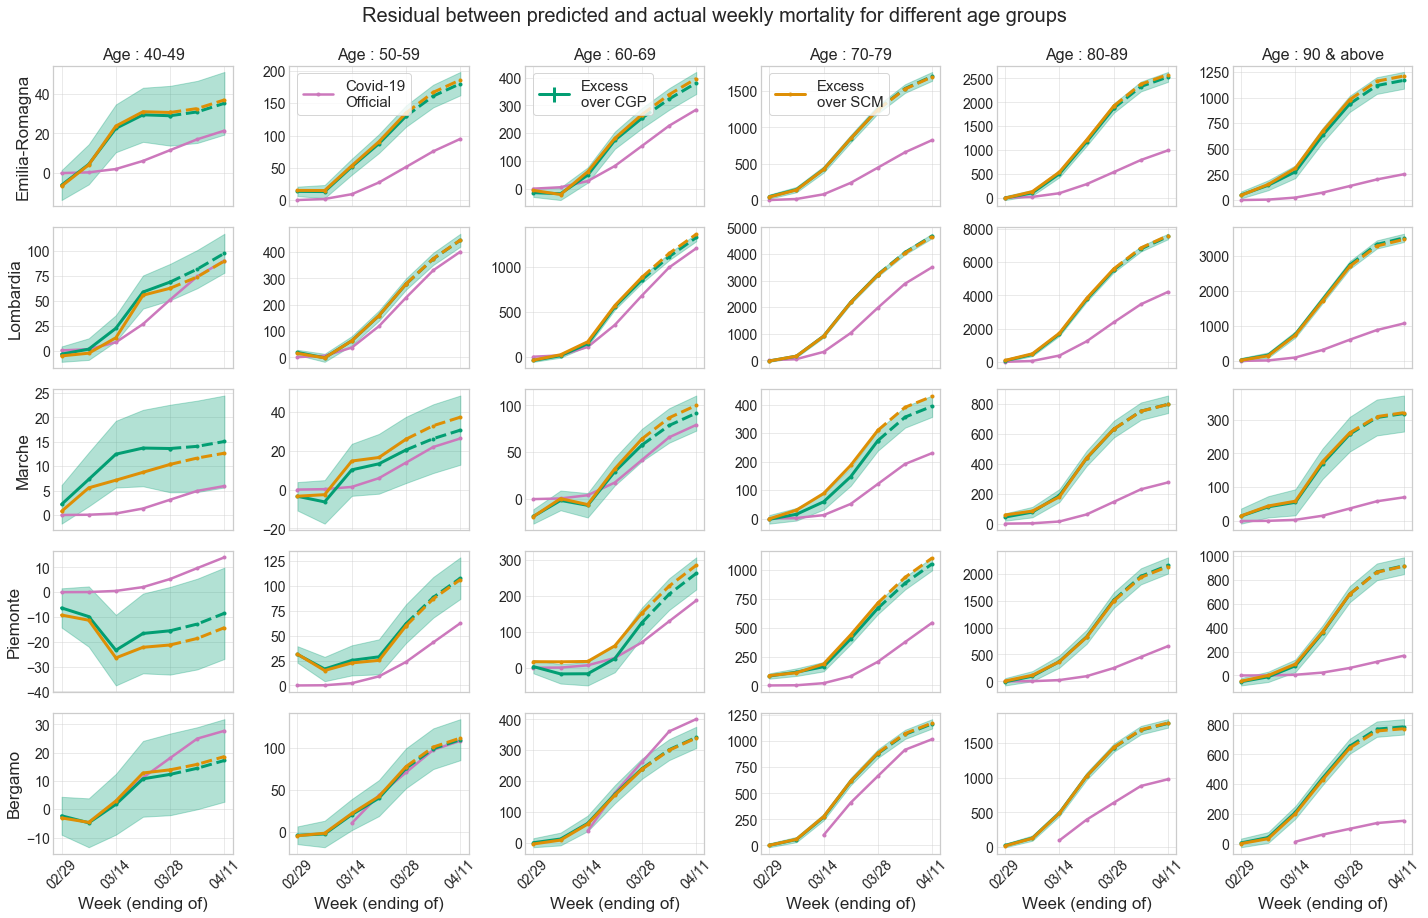

In [26]:
###  plot cumulative residuals for diferent age groups


Td = 5 #number of data points we have
isplit = [6] + [6+i*7 for i in range(1, 6)]
xlab = [i[-1] for i in np.split(dfcovid[dfcovid['region'] == 'Lombardia']['date'].values, isplit)]
xlab = [i.split('-')[1]+'/'+i.split('-')[2].split('T')[0] for i in xlab]
xlab[-1] = '04/11'

fig, ax = plt.subplots(5, 6, figsize=(20, 13), sharex=True)
axf = ax.T.flatten()
plt.subplots_adjust(hspace=0.01, wspace=0.015)
axn = 0 

for age in range(4, 10):
    
    for ir, region in enumerate(['Emilia-Romagna', 'Lombardia', 'Marche', 'Piemonte', 'Bergamo']):
        
        scale = deathscaling2[region]
        key = region + '%d'%age
        xplot = np.arange(aextrapcovid[key].size)

        lbl = None 
        if axn == 5: lbl = "Covid-19\nOfficial"
        yy = np.cumsum(aextrapcovid[key])
        if region == 'Bergamo': axf[axn].plot(xplot[2:], yy[2:], marker='.', lw=2.5, color='C4', label=lbl)
        else: axf[axn].plot(xplot, yy, marker='.', lw=2.5, color='C4', label=lbl)
#         axf[axn].plot(xplot, yy, marker='.', lw=3, color='r', label=lbl)

        #
        
        lbl = None 
        if axn == 10: lbl = "Excess\nover CGP"
        yy = np.cumsum(aextrapcgpmean[key])
        yyerr = np.cumsum(aextrapcgpmeaner[key]**2)**0.5 *0
        axf[axn].errorbar(xplot[:Td], yy[:Td], yyerr[:Td], 
                          color='C2', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td-1:], yy[Td-1:], yyerr[Td-1:], 
                          color='C2', ls = "--", marker='.', lw=3)
        yyerr = np.cumsum(aextrapcgpmeaner[key]**2)**0.5
        axf[axn].fill_between(xplot, yy-yyerr, yy+yyerr,
                          color='C2', alpha=0.3)
        
        lbl = None 
        if axn == 15: lbl = "Excess\nover SCM"
        yy = np.cumsum(aextrapscmmean[key])
        axf[axn].errorbar(xplot[:Td], yy[:Td], 
                          color='C1', ls = "-", marker='.', lw=3, label=lbl)
        axf[axn].errorbar(xplot[Td-1:], yy[Td-1:], 
                          color='C1', ls = "--", marker='.', lw=3)
        #

        if ir == 0: axf[axn].set_title('Age : ' + agegroups[age], fontsize=16)
#         if axn == 10: axf[axn].legend(fontsize=15, ncol=3, 
#                                       loc='upper center', bbox_to_anchor=(1.075, 1.415), frameon=False)
        if axn in [5, 10, 15]: axf[axn].legend(fontsize=15, ncol=1, loc=2)
        if age == 4: axf[axn].set_ylabel(region, fontsize=17)
        axf[axn].grid(which = 'both', lw=0.5, alpha=0.8)
        axf[axn].tick_params('both', direction='in')        
        axn +=1
    

for axis in ax[-1,:]:
    axis.set_xticks(xplot[::2])
    axis.set_xticklabels(xlab[::2])
    axis.set_xlabel('Week (ending of)', fontsize=17)
# for axis in ax[:,0]:
#     axis.set_ylabel('Total mortality count', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
#     plt.axhline(0, color='k', lw=0.5)
    
plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Residual between predicted and actual weekly mortality for different age groups', fontsize=20)
# plt.savefig('../paper_figs/residuals_cumulative_age.pdf')
# plt.savefig('../paper_figs/residuals_cumulative_age.jpeg')
plt.show()

### plot lower bound IFR and PFR

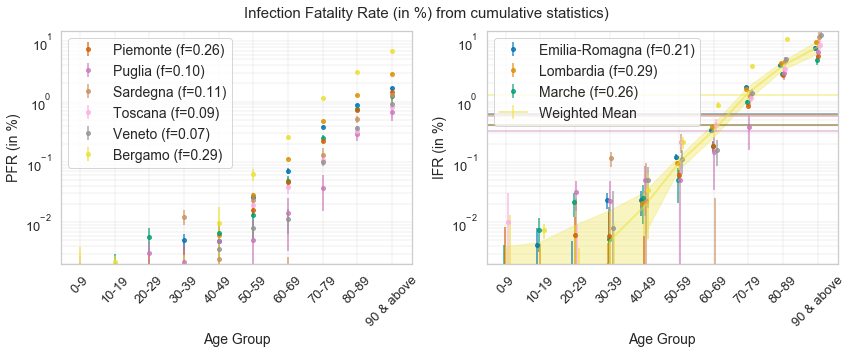

In [27]:
## Get mean estimates and error bars for IFR

vals =  np.array([ifrcgp_ex[region] for region in mainregions])
valserr =  np.array([ifrcgper_ex[region] for region in mainregions])
wts = valserr**-2
ifrcgpmean = (vals*wts).sum(axis=0) / wts.sum(axis=0)
ifrcgpstd =  ((wts * (vals-ifrcgpmean)**2).sum(axis=0)/wts.sum(axis=0))**0.5 *1
# ifrcgpstd =  (1/wts.sum(axis=0))**0.5

vals =  np.array([ifrtot_ex[region][0] for region in mainregions])
valserr =  np.array([ifrtot_ex[region][1] for region in mainregions])
wts = valserr**-2
ifrcgptotmean = (vals*wts).sum(axis=0) / wts.sum(axis=0)
# ifrcgptotstd =  (1/wts.sum(axis=0))**0.5 *1
ifrcgptotstd =  ((wts * (vals-ifrcgptotmean)**2).sum()/wts.sum(axis=0))**0.5 *1

###############################################
## Plot

xx = np.arange(len(agegroups))

##
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for ir, region in enumerate(mainregionsb):

    fpos = fpositive_ex[region][-1]
    lbl1, lbl2 = None, None
    if ir < 3: lbl1 = region + ' (f=%0.2f)'%fpos 
    if ir >= 3: lbl2 = region + ' (f=%0.2f)'%fpos 

    ax[1].errorbar(xx+ir*0.025-0.08, ifrcgp_ex[region], ifrcgper_ex[region], 
                   fmt='o', color='C%d' %ir, label=lbl1, markersize=4, alpha=0.8)
    
    yy, yyerr = np.array(ifrcgp_ex[region])*fpos, np.array(ifrcgper_ex[region])*fpos
    ax[0].errorbar(xx, yy, yyerr,
                 label=lbl2, fmt='o', color='C%d' %ir, markersize=4, alpha=0.8)

#     xx2 = np.arange(ir, ir+2)
    yy, yyer = ifrtot_ex[region]
    plt.axhline(yy, color='C%d'%ir, alpha=0.5)
    
ax[1].errorbar(xx, ifrcgpmean, ifrcgpstd, lw=2, color='y', alpha=0.5, label='Weighted Mean')
ax[1].fill_between(xx, ifrcgpmean-ifrcgpstd, ifrcgpmean+ifrcgpstd, color='y', alpha=0.3)
# xx2 = np.arange(ir+1, ir+3)
# plt.axhline(ifrcgptotmean, color='C%d'%ir, alpha=0.5)
# plt.fill_between(xx2, ifrcgptotmean - ifrcgptotstd, ifrcgptotmean + ifrcgptotstd, color='y', alpha=0.3)

    

for axis in ax:
    axis.legend(fontsize=14, ncol=1, loc=0)
    axis.grid(which = 'both', lw=0.3)
    axis.set_xticks(xx)
    axis.set_xticklabels(agegroups[:])
    axis.set_xlabel('Age Group', fontsize=14)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=13)
    plt.yticks(fontsize=13)
    plt.yscale('log')
ax[1].set_ylabel('IFR (in %)', fontsize=14)
ax[1].set_ylim(1e-2/5, 15)
ax[0].set_ylabel('PFR (in %)', fontsize=14)
ax[0].set_ylim(1e-2/5, 15)    

plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Infection Fatality Rate (in %) from cumulative statistics)', fontsize=15)

plt.show()


### One stop shop : IF and P-IF as function to IFR

No handles with labels found to put in legend.


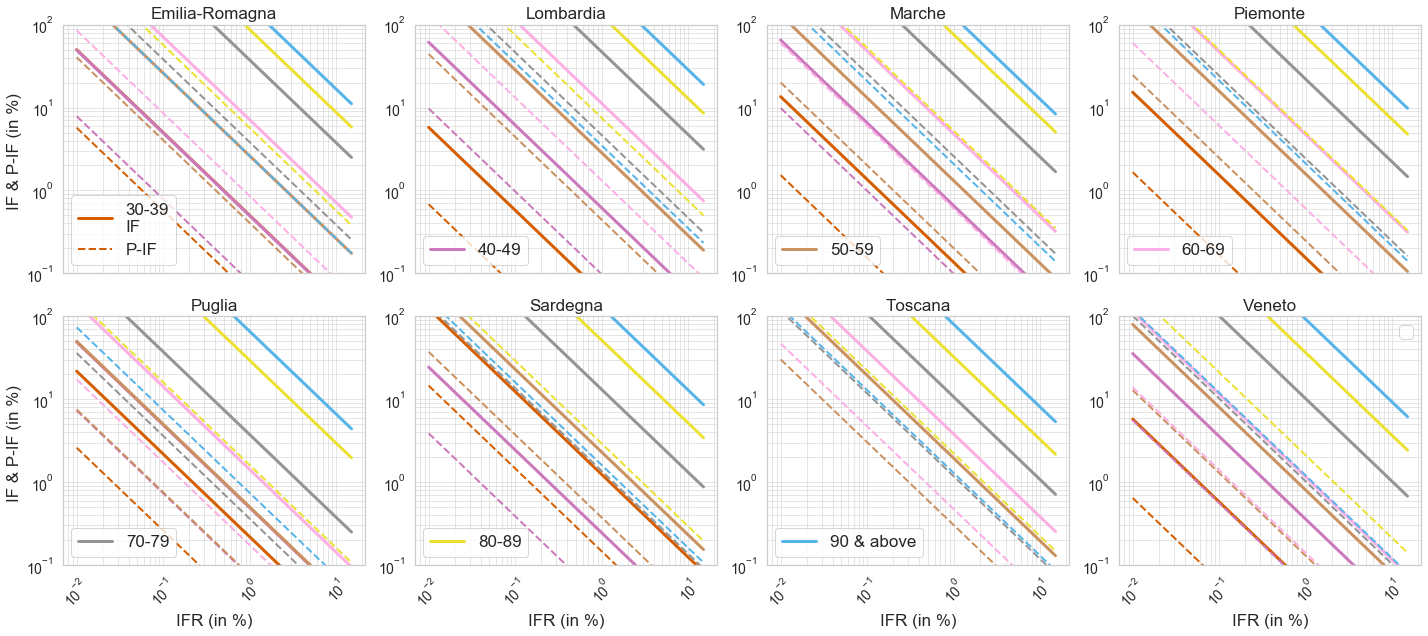

In [28]:
xx = np.linspace(0.01, 15)

fig, ax = plt.subplots(2, 4, figsize=(20, 9), sharex=True)
axf = ax.flatten()
axn = 0 

for ir, region in enumerate(mainregions):
    pfr = (ifrcgp_ex[region] * fpositive_ex[region][0] )
    agefac = agedict[region].copy()
    agefac /= agefac.sum()
    lbl, lbl1 = None, None
    for ia in range(3, 10):
        if axn == ia-3: lbl = agegroups[ia]
        if (axn == 0) & (ia == 3): 
            lbl = lbl + '\nIF'
            lbl1 = "P-IF"
        axf[axn].plot(xx, 100*(pfr[ia] /xx), color='C%d'%ia, label=lbl, lw=3)
        axf[axn].plot(xx, 100*(pfr[ia] * agefac[ia]/xx), color='C%d'%ia, ls="--", lw=2, label=lbl1)
        lbl, lbl1 = None, None
        
    axf[axn].set_title(region, fontsize=17)
    axf[axn].legend(fontsize=17, ncol=1, loc=0)
    axf[axn].grid(which = 'both', lw=0.5)
    axn +=1
    
for axis in ax[1, :]: 
    axis.set_xlabel('IFR (in %)', fontsize=17)
for axis in ax[:, 0]:
    axis.set_ylabel('IF & P-IF (in %) ', fontsize=17)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.loglog()
    plt.ylim(1e-1, 100)

plt.tight_layout()
plt.show()

# Diamond Princess Data

In [36]:
def poisson_interval(k, alpha=0.05): 
    """
    uses chisquared info to get the poisson interval. Uses scipy.stats 
    (imports in function). 
    """
    from scipy.stats import chi2
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return low, high

poisson_interval(11)

(5.49116036723684, 19.682038513301954)

In [30]:
# Data scraped manully

dpages = np.array([16,23,347,428,334,398,923,1015,216])
dpsym = np.array([0, 2,25,27,19,28,76,95,29])
dpasym = np.array([1,3,3,7,8,31,101,139,25])
dpinfect = dpsym + dpasym
dpdeath = np.array([0,0,0,0,0,0,1,7,4])

dpages[-2]/dpages.sum(), dpages[-1]/dpages.sum()

(0.2743243243243243, 0.05837837837837838)

We have to weight in the proportion of the population in 70-79, 80-89 in DP <br>
So ratio is - 1015/(1015 + 216 + 11), (/(1015 + 216) i.e 0.824, 0176



In [31]:
w1, w2 = dpages[-2:]/dpages[-2:].sum()
print(w1, w2)
dpifr = (dpdeath[-2:].sum()/dpinfect[-2:].sum()) * 100
dpifr = 11/330 * 100
deldpifr0 = 5.49/330 * 100
deldpifr1 = 19.68/330 * 100

0.8245329000812348 0.17546709991876522


## Get IFR when normalized to DP and Table 1

In [32]:
table = []
ifrtotdp = {}
ifrcgpdp = {}
ifrcgpdperr = {}

for region in mainregionsb:
    if (deathscaling2[region] < 10) :
        
        fpos =  fpositive_ex[region][0] * 100 
        ifr0 =  '%0.2f'%(ifrtot_ex[region][0]) 
        cvdeath = extrapcovid[region].sum()
        scale = deathscaling2[region]
        
        pfr = ifrcgp_ex[region]  * fpos
        pfrw = pfr[-3]*w1 + pfr[-2]*w2
        fr = pfrw / dpifr
        fr0, fr1 = fr-(pfrw/dpifr**2)*(dpifr-deldpifr0), fr+(pfrw/dpifr**2)*(deldpifr1-dpifr)
        ifr2 = ifrtot_ex[region][0] * fpos /fr
        ifrtotdp[region] = ifr2
        
        ifrcgpdp[region] = ifrcgp_ex[region] * fpos /fr
        d1, d2 = (fr-fr0), (fr1-fr)
        if0, if1 = ifrcgpdp[region]-  ifrcgp_ex[region] * fpos /fr**2 *d1, ifrcgpdp[region] + ifrcgp_ex[region] * fpos /fr**2 *d2
        ifrcgpdperr[region] = [if0, if1]
        
        pred = '%d $\pm$ %d'%(int(extrapcgpmean[region].sum()), int(((extrapcgpmeaner[region]**2).sum())**0.5))
        
        table.append([region,  '%0.3f'%(popdict[region]/1e6), cvdeath , 
                      '%0.2f'%scale, 
                      pred,
                      '%0.2f'%(fpos/100), ifr0, 
                      '%0.2f (%0.2f-%0.2f)'%(fr/100,fr0/100, fr1/100), '%0.2f'%ifr2])
# pd.DataFrame.from_dict(tmp)

In [33]:
table = pd.DataFrame(table, columns=['Region', 'Population', 'COVID-19', 'Scale', 'Total', 
                                     'IR0', 'IFR0', 
                                     'IR-DP', 'IFR-DP' ])

# print(pd.DataFrame.from_dict(table).to_latex(index=False, header=False, columns=table.columns[:-1]))
table

,Region,Population,COVID-19,Scale,Total,IR0,IFR0,IR-DP,IFR-DP
0,Emilia-Romagna,4.459,2481,2.02,6013 $\pm$ 204,0.21,0.63,0.14 (0.07-0.25),0.97
1,Lombardia,10.061,10511,1.50,17786 $\pm$ 269,0.29,0.60,0.18 (0.09-0.33),0.96
2,Marche,1.525,689,3.18,1650 $\pm$ 119,0.26,0.42,0.10 (0.05-0.18),1.06
3,Piemonte,4.356,1633,3.09,4627 $\pm$ 237,0.26,0.42,0.09 (0.05-0.16),1.15
4,Puglia,4.029,253,5.82,1271 $\pm$ 200,0.10,0.32,0.02 (0.01-0.04),1.27
5,Sardegna,1.640,73,6.20,1005 $\pm$ 134,0.11,0.57,0.06 (0.03-0.11),1.03
6,Toscana,3.730,467,3.59,1995 $\pm$ 207,0.09,0.58,0.04 (0.02-0.08),1.23
7,Veneto,4.906,831,2.97,2232 $\pm$ 151,0.07,0.63,0.04 (0.02-0.08),1.03
8,Bergamo,1.115,2693,1.00,4260 $\pm$ 87,0.29,1.30,0.45 (0.22-0.80),0.86


## Plot realistic IFR with DP estimates 

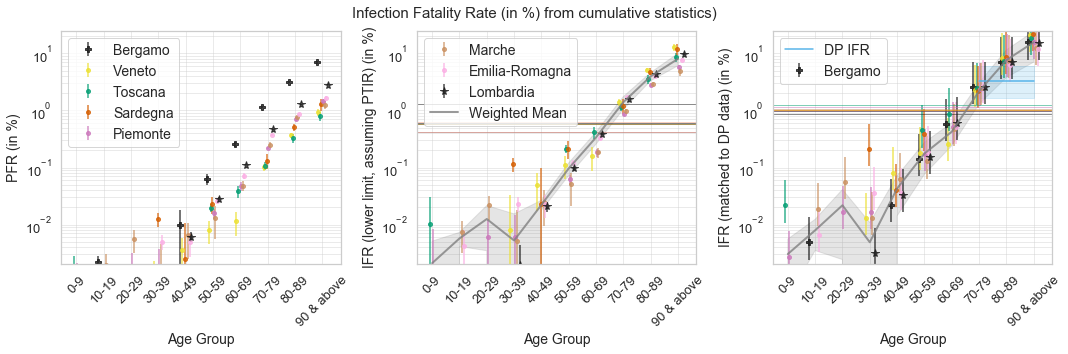

In [34]:
#Change order of plotting to highlight Lombarida
mainregionsb2 = np.array(mainregionsb).copy()
mainregionsb2 = np.concatenate([mainregionsb2[2:][::-1], mainregionsb2[[0, 1]] ])
mainregionsb2 = [i for i in mainregionsb2 if i != 'Puglia']


##Get error estimates of the IFR
vals =  np.array([ifrcgp_ex[region] for region in mainregions])
valserr =  np.array([ifrcgper_ex[region] for region in mainregions])
wts = valserr**-2
wts[vals<0] = 0
ifrcgpmean = (vals*wts).sum(axis=0) / wts.sum(axis=0)
ifrcgpstd =  ((wts * (vals-ifrcgpmean)**2).sum(axis=0)/wts.sum(axis=0))**0.5 *1
# ifrcgpstd =  (1/wts.sum(axis=0))**0.5

vals =  np.array([ifrtot_ex[region][0] for region in mainregions])
valserr =  np.array([ifrtot_ex[region][1] for region in mainregions])
wts = valserr**-2
wts[vals<0] = 0
ifrcgptotmean = (vals*wts).sum(axis=0) / wts.sum(axis=0)
# ifrcgptotstd =  (1/wts.sum(axis=0))**0.5 *1
ifrcgptotstd =  ((wts * (vals-ifrcgptotmean)**2).sum()/wts.sum(axis=0))**0.5 *1


vals =  np.array([ifrcgpdp[region] for region in mainregions])
valserr =  np.array([ifrcgpdperr[region] for region in mainregions])
wts = ((valserr**2).sum(axis=1)**0.5)**-2.
wts[vals<0] = 0
ifrcgpmeandp = (vals*wts).sum(axis=0) / wts.sum(axis=0)
ifrcgpstddp =  ((wts * (vals-ifrcgpmean)**2).sum(axis=0)/wts.sum(axis=0))**0.5 *1


xx = np.arange(len(agegroups))

##
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

for ir, region in enumerate(mainregionsb2[:] ):

    fpos = fpositive_ex[region][-1]
    lbl1, lbl2, lbl3 = None, None, None
    if ir <= 4: lbl1 = region 
    if ir > 4: lbl2 = region 
    if region == "Bergamo" : lbl3 = 'Bergamo'
    msize, fmt, cc, al  = 4, 'o', 'C%d'%ir, 0.8    
    if region == 'Veneto' : cc = 'y'
    if region == 'Lombardia': msize, fmt, cc, al = 8, '*', 'k', 0.8
    if region == 'Bergamo': msize, fmt, cc, al = 6, 'P', 'k', 0.8
    
    xx2 = xx + ir*0.06-0.211
    yy, yyerr = np.array(ifrcgp_ex[region])*fpos, np.array(ifrcgper_ex[region])*fpos
    yy[yy<0] = np.NaN
    ax[0].errorbar(xx2, yy, yyerr,
                 label=lbl1, fmt=fmt, color=cc, markersize=msize, alpha=al)
    
    yy, yyerr = ifrcgp_ex[region].copy(), ifrcgper_ex[region].copy()
    yy[yy<0] = np.NaN
    if region != 'Bergamo': ax[1].errorbar(xx2, yy, yyerr, 
                   fmt=fmt, color=cc, label=lbl2, markersize=msize, alpha=al)
    
    yy, yyerr = ifrcgpdp[region].copy(), np.array(ifrcgpdperr[region].copy())
    yy[yy<0] = np.NaN
    ax[2].errorbar(xx2, yy, yyerr,
                 fmt=fmt, color=cc, markersize=msize, alpha=al, label=lbl3)
    
    ax[1].axhline(ifrtot_ex[region][0], color=cc, lw=0.5)
    ax[2].axhline(ifrtotdp[region], color=cc, lw=0.5)
    

cc = 'gray'
ax[1].errorbar(xx, ifrcgpmean,  lw=2, color=cc, alpha=0.8, label='Weighted Mean')
ax[1].fill_between(xx, ifrcgpmean-ifrcgpstd, ifrcgpmean+ifrcgpstd, color=cc, alpha=0.2)

ax[2].errorbar(xx, ifrcgpmeandp, lw=2, color=cc, alpha=0.8)
ax[2].fill_between(xx, ifrcgpmeandp-ifrcgpstddp, ifrcgpmeandp+ifrcgpstddp, color=cc, alpha=0.2)

ax[2].plot(xx[-3:], xx[-3:]*0 + dpifr, label="DP IFR", alpha=1.0, color='C9')
ax[2].fill_between(xx[-3:], deldpifr0, deldpifr1, alpha=0.2, color='C9')
    

for axis in ax:
    axis.legend(fontsize=14, ncol=1, loc=0)
    axis.grid(which = 'both',  alpha=0.8, lw=0.5)
    axis.set_xticks(xx)
    axis.set_xticklabels(agegroups[:])
    axis.set_xlabel('Age Group', fontsize=14)
    axis.set_ylim(1e-2/5, 25)
for axis in fig.axes:
    matplotlib.pyplot.sca(axis)
    plt.xticks(rotation=45, fontsize=13)
    plt.yticks(fontsize=13)
    plt.yscale('log')
    
ax[0].set_ylabel('PFR (in %)', fontsize=14)
ax[1].set_ylabel('IFR (lower limit, assuming PTIR) (in %)', fontsize=14)
ax[2].set_ylabel('IFR (matched to DP data) (in %)', fontsize=14)

plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Infection Fatality Rate (in %) from cumulative statistics)', fontsize=15)
# plt.savefig('../paper_figs/ifr.pdf')
# plt.savefig('../paper_figs/ifr.jpeg')

plt.show()


# Table 2 for the paper with age distribution

In [35]:
Ages =  ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90 & above']

table = []
for rr in ['Lombardia', 'Bergamo', 'Emilia-Romagna']:
    table.append([rr, "", "", "", "", "", ""])
    tots, totscovid = 0, 0 
    for age in range(0, 10):
        key = rr+'%d'%age
        dd, dderr = int(aextrapcgpmean[key].sum()), int((aextrapcgpmeaner[key]**2).sum()**0.5)
        dd2, dderr = int(aextrapcovid[key].sum()), int((aextrapcgpmeaner[key]**2).sum()**0.5)
        tots += dd
        totscovid += dd2
        
    for age in range(4, 10):
        tmp = ['']
        tmp.append(Ages[age])
        key = rr+'%d'%age
        tmp.append('%0.3f'%(agedict[rr][age]/popdict[rr]))
        tmp.append('%0.2f'%(aextrapcovid[key].sum()/totscovid))
        dd, dderr = int(aextrapcgpmean[key].sum()), int((aextrapcgpmeaner[key]**2).sum()**0.5)
        tmp.append('%0.3f $\pm$ %0.3f'%(dd/tots, dderr/tots))
        dd, dderr = ifrcgp_ex[rr][age], ifrcgper_ex[rr][age]
        if rr == 'Bergamo' : 
            dd = dd*fpositive_ex['Lombardia'][-1]
            dderr = dd*fpositive_ex['Lombardia'][-1]
        tmp.append('%0.2f $\pm$ %0.2f'%(dd, dderr))
        tmp.append('%0.2f (%0.2f-%0.2f)'%(ifrcgpdp[rr][age], ifrcgpdperr[rr][0][age], ifrcgpdperr[rr][1][age]))
        table.append(tmp)
table = pd.DataFrame(table, columns = ['', 'Age groups', 'Population Fraction', 'Covid Fraction', 'Excess Fraction', 'IFR (lower)', 'IFR (DP)'])
# print(table.to_latex(index=False, header=False))

table

,,Age groups,Population Fraction,Covid Fraction,Excess Fraction,IFR (lower),IFR (DP)
0,Lombardia,,,,,,
1,,40-49,0.158,0.01,0.006 $\pm$ 0.001,0.02 $\pm$ 0.00,0.03 (0.02-0.06)
2,,50-59,0.156,0.04,0.025 $\pm$ 0.001,0.10 $\pm$ 0.01,0.15 (0.08-0.28)
3,,60-69,0.118,0.11,0.075 $\pm$ 0.002,0.38 $\pm$ 0.01,0.61 (0.30-1.09)
4,,70-79,0.099,0.33,0.266 $\pm$ 0.005,1.60 $\pm$ 0.03,2.56 (1.28-4.58)
5,,80-89,0.058,0.40,0.429 $\pm$ 0.009,4.37 $\pm$ 0.10,6.97 (3.48-12.48)
6,,90 & above,0.012,0.10,0.200 $\pm$ 0.007,9.71 $\pm$ 0.32,15.50 (7.74-27.74)
7,Bergamo,,,,,,
8,,40-49,0.157,0.01,0.004 $\pm$ 0.003,0.01 $\pm$ 0.00,0.02 (0.01-0.04)
9,,50-59,0.157,0.04,0.026 $\pm$ 0.006,0.06 $\pm$ 0.02,0.14 (0.07-0.25)
